In [1]:
from scipy.io import loadmat
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from itertools import product, combinations
from sklearn.model_selection import train_test_split

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple, Dict, Any


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Generating Data


=== Alignment diagnostics (matching by (patient_id, case_id) as strings) ===
{'intra_unique_keys': 26904, 'post_unique_keys': 26955, 'intersection_keys': 26904, 'missing_in_post_y_count': 0, 'missing_in_intra_count': 51, 'missing_in_post_y_sample': [], 'missing_in_intra_sample': [('BAH0014070', 'BLH0013253'), ('BAH0006661', 'BLH0015509'), ('BAH0017194', 'BLH0016503'), ('BAH0018845', 'BLH0018407'), ('BAH0008319', 'BLH0006486'), ('BAH0012894', 'BLH0011512'), ('BAH0009868', 'BLH0015342'), ('BAH0020671', 'BLH0020631'), ('BAH0016512', 'BLH0015639'), ('BAH0016219', 'BLH0015300')]}

=== Post_y diagnostics ===
{'post_y_rows': 26955, 'post_y_unique_keys': 26955, 'post_y_duplicate_keys_count': 0, 'post_y_conflicting_label_keys_count': 0, 'post_y_conflicting_label_sample': []}

=== Pre_v diagnostics ===
{'pre_v_rows': 26955, 'pre_v_unique_keys': 26955, 'pre_v_duplicate_keys_count': 0, 'pre_v_duplicate_keys_sample': []}

=== Intra_v diagnostics ===
{'intra_v_rows': 26955, 'intra_v_unique_keys': 2

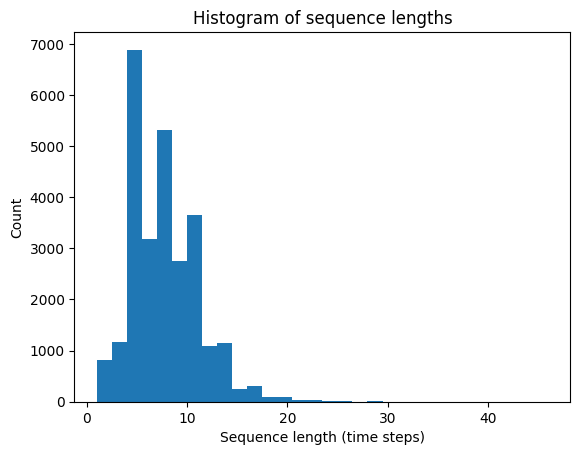


=== X normalization lists (based on TRAIN split stats) ===
x <- x / std (scale-only):
['intraoper_cumulative_HRV', 'intraoper_cumulative_hypothermia_auc', 'intraoper_cumulative_hypoxic_auc', 'intraoper_cumulative_MAP_auc', 'intraoper_FIO2_ArtBGA', 'intraoper_Oxygenation_index', 'intraoper_tHb_value', 'intraoper_BE_value', 'intraoper_cHCO3_value', 'intraoper_CVP_value', 'intraoper_Ca_value', 'intraoper_Na_value', 'intraoper_K_value', 'intraoper_Glu_value', 'intraoper_Lac_value', 'intraoper_PH_value', 'intraoper_Norepinephrine_max', 'intraoper_Dopamine_max', 'intraoper_Dobutamine_max', 'intraoper_Isoproterenol_max', 'intraoper_Adrenaline_max', 'intraoper_Milrinone_max', 'intraoper_Baquting_value', 'intraoper_Tranexamic_Acid_value', 'intraoper_Heparin_value', 'intraoper_protamine_value', 'intraoper_opioids_MME_value', 'intraoper_GCs_culmulative_value', 'intraoper_Platelets_culVolume', 'intraoper_Plasma_culVolume', 'intraoper_Autoblood_culVolume', 'CPBresidualBlood_culVolume', 'intraoper_

In [6]:
# transfusion_loaders_with_static_v.py
from __future__ import annotations
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict, Any, Set, Sequence

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt


# ============================================================
# Paths
# ============================================================
INTRA_XA_PATH = "/content/drive/MyDrive/coding/Dataset/transfusion/Intra_xa.csv"
POST_Y_PATH   = "/content/drive/MyDrive/coding/Dataset/transfusion/Post_y.csv"
PRE_V_PATH    = "/content/drive/MyDrive/coding/Dataset/transfusion/Pre_v.csv"
INTRA_V_PATH  = "/content/drive/MyDrive/coding/Dataset/transfusion/Intra_v.csv"


# ============================================================
# Column names
# ============================================================
PATIENT_ID_COL = "patient_id"
CASE_ID_COL    = "case_id"
TIME_COL       = "intraoper_time_periods"
ACTION_CUM_COL = "intraoper_pRBC_culVolume"
Y_LABEL_COL    = "AKI_class_occur"


# ============================================================
# Intra x columns (39)
# ============================================================
X_COLS: List[str] = [
    "intraoper_cumulative_HRV",
    "intraoper_cumulative_hypothermia_auc",
    "intraoper_cumulative_hypoxic_auc",
    "intraoper_cumulative_MAP_auc",
    "intraoper_FIO2_ArtBGA",
    "intraoper_Oxygenation_index",
    "intraoper_tHb_value",
    "intraoper_BE_value",
    "intraoper_cHCO3_value",
    "intraoper_CVP_value",
    "intraoper_Ca_value",
    "intraoper_Na_value",
    "intraoper_K_value",
    "intraoper_Glu_value",
    "intraoper_Lac_value",
    "intraoper_PH_value",
    "intraoper_Norepinephrine_max",
    "intraoper_Dopamine_max",
    "intraoper_Dobutamine_max",
    "intraoper_Isoproterenol_max",
    "intraoper_Adrenaline_max",
    "intraoper_Milrinone_max",
    "intraoper_Terlipressin_used",
    "intraoper_Esmolol_used",
    "intraoper_Baquting_value",
    "intraoper_Tranexamic_Acid_value",
    "intraoper_Ketamine_value",
    "intraoper_Heparin_value",
    "intraoper_protamine_value",
    "intraoper_opioids_MME_value",
    "intraoper_GCs_culmulative_value",
    "intraoper_Platelets_culVolume",
    "intraoper_Plasma_culVolume",
    "intraoper_Autoblood_culVolume",
    "CPBresidualBlood_culVolume",
    "intraoper_Inhalation_anesthetics",
    "intraoper_Propofol_used",
    "intraoper_colloid_culVolume",
    "isultrafilter_used",
]


# ============================================================
# Static v columns
# ============================================================
PRE_V_COLS: List[str] = [
    "gender",  # 男/女
    "adm_age",
    "ethnicity",
    "BMI",
    "cardiac_surgery_history_adm",
    "renal_surgery_history_adm",
    "allergy_history_adm",
    "drinking_history_adm",
    "smoking_history_adm",
    "transfusion_history_adm",
    "preoper_DBP",
    "preoper_Heart_Rate",
    "preoper_Pulse",
    "preoper_SBP",
    "preoper_Temperature",
    "preoper_Respiratory_Rate",
    "d_Valve_Dis",
    "d_Rheumatic_HD",
    "d_Congenital_HD",
    "d_Aortic_related_dis",
    "d_Coronary_HD",
    "d_Cardiac_Tumor",
    "d_Cardiomyopathy",
    "d_Infect_Endocarditis",
    "d_Pericardial_Dis",
    "d_Liver_Disease",
    "d_CKD_Status",
    "d_NYHA_Level",
    "d_Cerebrovascular_Events",
    "d_AF_af_Arrhythmia",
    "d_arrhy_avb",
    "d_arrhy_cp_icd_crt",
    "d_auto_immune",
    "d_copd",
    "d_dm",
    "d_hyper_hypo_thyroidism",
    "d_lipn",
    "d_pvd",
    "d_sepsis",
    "d_htn",
    "d_pulmonary_hypertension",
    "preoperLab_NT_proBNP",
    "preoperLab_CRP",
    "preoperLab_Neutrophil_Percentage",
    "preoperLab_eGFR",
    "preoperLab_PT",
    "preoperLab_TBIL",
    "preoperLab_APTT",
    "preoperLab_WBC_Count",
    "preoperLab_ALB",
    "preoperLab_RBC_Count",
    "preoperLab_TnT",
    "preoperLab_Cystatin_C",
    "preoperLab_Platelet_Count",
    "preoperLab_BUN",
    "preoperLab_ESR",
    "preoperLab_Hemoglobin",
    "preoperLab_Glucose",
    "preoper_LVEF",
    "preoperDrug_Glucocorticoid_Usage",
    "preoperDrug_Amphotericin_Aminoglycoside_Combined_Usage",
    "preoperDrug_ACEIARB_Usage",
    "preoperDrug_Diuretics_Usage",
    "preoperDrug_NSAIDs_Usage",
    "preoperDrug_Norepinephrine",
    "preoperDrug_vasopressinUSE",
    "preoperDrug_Dopamine",
    "preoperDrug_Nitroprusside",
    "preoperDrug_Dobutamine",
    "preoperDrug_Isoproterenol",
    "preoperDrug_Epinephrine",
    "preoperDrug_Nitroglycerin",
    "preoperDrug_Metaraminol",
    "preoperDrug_Contrast_Exposure",
    "pre_aki",
]

INTRA_V_COLS: List[str] = [
    "is_emergency",  # 1 non-emergency, 2 emergency (binary)
    "ASA_class",     # 1..5 (we support ordinal or onehot)
    "CABG_oper",
    "CardiacTumor_oper",
    "HeartTransplant_oper",
    "aortic_oper",
    "congenital_oper",
    "valve_oper",
]


# ============================================================
# ID cleaning
# ============================================================
def _clean_id_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)
    s = s.replace({"nan": "", "None": "", "<NA>": ""})
    return s

def normalize_patient_id(s: pd.Series, width: Optional[int] = None) -> pd.Series:
    s = _clean_id_series(s)
    if width is None:
        return s
    is_digits = s.str.fullmatch(r"\d+").fillna(False)
    s.loc[is_digits] = s.loc[is_digits].str.zfill(width)
    return s

def normalize_case_id(s: pd.Series) -> pd.Series:
    return _clean_id_series(s)


# ============================================================
# Action bins
# ============================================================
_ACTION_BINS = np.array([0, 1, 2, 3, 4, 5], dtype=np.float32)

def bin_incremental_action(delta: np.ndarray) -> np.ndarray:
    delta = np.asarray(delta, dtype=np.float32)
    delta = np.clip(delta, 0.0, np.inf)
    return np.digitize(delta, bins=_ACTION_BINS, right=True).astype(np.int64)


# ============================================================
# Collate: now returns x, a, y, v, lengths, mask
# ============================================================
def pad_collate_varlen(batch, pad_action: int = 0):
    xs, aas, ys, vs, lens = zip(*batch)
    lengths = torch.stack(lens, dim=0)
    B = len(batch)
    T_max = int(lengths.max().item())
    x_dim = xs[0].shape[-1]
    v_dim = vs[0].shape[-1]

    x_pad = torch.zeros(B, T_max, x_dim, dtype=torch.float32)
    a_pad = torch.full((B, T_max), fill_value=int(pad_action), dtype=torch.long)

    # FIX: y is (B,1) to match the simulator + your model assumptions
    y = torch.stack(ys, dim=0).to(dtype=torch.float32).view(B, 1)

    v = torch.stack(vs, dim=0).to(dtype=torch.float32).view(B, v_dim)

    for i, (x_i, a_i, L) in enumerate(zip(xs, aas, lengths)):
        L = int(L.item())
        x_pad[i, :L, :] = x_i
        a_pad[i, :L] = a_i

    t = torch.arange(T_max).unsqueeze(0).expand(B, T_max)
    mask = t < lengths.unsqueeze(1)
    return x_pad, a_pad, y, v, lengths, mask


# ============================================================
# Diagnostics helpers (reuse from your current code)
# ============================================================
def infer_cumulative_cols(x_cols: List[str]) -> Set[str]:
    keys = ["cumulative", "culmulative", "culvolume", "_auc", "auc"]
    out = set()
    for c in x_cols:
        cl = c.lower()
        if any(k in cl for k in keys):
            out.add(c)
    return out

def diff_within_surgery(df: pd.DataFrame, col: str) -> pd.Series:
    d = df.groupby([PATIENT_ID_COL, CASE_ID_COL], sort=False)[col].diff()
    d = d.fillna(df[col])
    d = d.clip(lower=0.0)
    return d.astype(np.float32)

def detect_binary_cols(df: pd.DataFrame, cols: List[str]) -> Set[str]:
    binary = set()
    for c in cols:
        if c not in df.columns:
            continue
        v = df[c].dropna()
        if v.empty:
            continue
        uniq = np.unique(v.to_numpy(dtype=np.float32))
        if len(uniq) <= 2 and set(uniq.tolist()).issubset({0.0, 1.0}):
            binary.add(c)
    return binary

def list_negative_cols(df: pd.DataFrame, cols: List[str]) -> List[str]:
    neg = []
    for c in cols:
        if c not in df.columns:
            continue
        try:
            if float(df[c].min()) < 0:
                neg.append(c)
        except Exception:
            pass
    return sorted(neg)

def alignment_diagnostics(intra_keys: Set[Tuple[str, str]], post_keys: Set[Tuple[str, str]], sample_n: int = 10) -> Dict[str, Any]:
    inter = intra_keys & post_keys
    only_in_intra = list(intra_keys - post_keys)
    only_in_post  = list(post_keys - intra_keys)
    return {
        "intra_unique_keys": len(intra_keys),
        "post_unique_keys": len(post_keys),
        "intersection_keys": len(inter),
        "missing_in_post_y_count": len(only_in_intra),
        "missing_in_intra_count": len(only_in_post),
        "missing_in_post_y_sample": only_in_intra[:sample_n],
        "missing_in_intra_sample": only_in_post[:sample_n],
    }


# ============================================================
# Post_y loader + diagnostics
# ============================================================
def load_post_y_with_diagnostics(post_y_path: str, pid_width: Optional[int] = None) -> Tuple[Dict[Tuple[str, str], int], Dict[str, Any]]:
    dfy = pd.read_csv(
        post_y_path,
        dtype={PATIENT_ID_COL: "string", CASE_ID_COL: "string"},
        low_memory=False
    )

    dfy[PATIENT_ID_COL] = normalize_patient_id(dfy[PATIENT_ID_COL], width=pid_width)
    dfy[CASE_ID_COL]    = normalize_case_id(dfy[CASE_ID_COL])

    dfy[Y_LABEL_COL] = pd.to_numeric(dfy[Y_LABEL_COL], errors="coerce")
    dfy = dfy.dropna(subset=[Y_LABEL_COL])
    dfy = dfy[dfy[Y_LABEL_COL].isin([0, 1])]

    dup_counts = dfy.groupby([PATIENT_ID_COL, CASE_ID_COL]).size()
    dup_keys = dup_counts[dup_counts > 1].index.tolist()

    conflict_keys = []
    if dup_keys:
        nunique = dfy.groupby([PATIENT_ID_COL, CASE_ID_COL])[Y_LABEL_COL].nunique()
        conflict_keys = nunique[nunique > 1].index.tolist()

    dfy = dfy.drop_duplicates(subset=[PATIENT_ID_COL, CASE_ID_COL], keep="last")

    label_map: Dict[Tuple[str, str], int] = {}
    for _, r in dfy.iterrows():
        key = (str(r[PATIENT_ID_COL]), str(r[CASE_ID_COL]))
        label_map[key] = int(r[Y_LABEL_COL])

    diag = {
        "post_y_rows": int(len(dfy)),
        "post_y_unique_keys": int(len(label_map)),
        "post_y_duplicate_keys_count": int(len(dup_keys)),
        "post_y_conflicting_label_keys_count": int(len(conflict_keys)),
        "post_y_conflicting_label_sample": conflict_keys[:10],
    }
    return label_map, diag


# ============================================================
# Static v loaders
#   - ethnicity: one-hot (train-fitted) + UNK bucket
#   - ASA_class: default one-hot (1..5) + UNK, or ordinal
# ============================================================
def _safe_read_csv(path: str, encoding: Optional[str] = None, **kwargs) -> pd.DataFrame:
    try:
        return pd.read_csv(path, encoding=encoding, **kwargs)
    except UnicodeDecodeError:
        # fallback (common in csv exports)
        return pd.read_csv(path, encoding="utf-8-sig", **kwargs)

def load_pre_v_df(pre_v_path: str, pid_width: Optional[int] = None) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    df = _safe_read_csv(
        pre_v_path,
        encoding="utf-8",
        dtype={PATIENT_ID_COL: "string", CASE_ID_COL: "string"},
        low_memory=False
    )

    df[PATIENT_ID_COL] = normalize_patient_id(df[PATIENT_ID_COL], width=pid_width)
    df[CASE_ID_COL]    = normalize_case_id(df[CASE_ID_COL])

    missing = [c for c in PRE_V_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in Pre_v.csv: {missing}")

    keep = [PATIENT_ID_COL, CASE_ID_COL] + PRE_V_COLS
    df = df[keep].copy()

    # gender: 男=1, 女=0
    g = df["gender"].astype(str).str.strip()
    df["gender"] = np.where(g == "男", 1.0, np.where(g == "女", 0.0, np.nan)).astype(np.float32)

    # ethnicity: keep as string (encoded later)
    df["ethnicity"] = df["ethnicity"].astype(str).str.strip().replace({"nan": "", "None": "", "<NA>": ""})

    # numeric conversions for the rest (leave ethnicity)
    numeric_cols = [c for c in PRE_V_COLS if c not in ["gender", "ethnicity"]]
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[numeric_cols] = df[numeric_cols].astype(np.float32)

    # duplicates diagnostics
    dup_counts = df.groupby([PATIENT_ID_COL, CASE_ID_COL]).size()
    dup_keys = dup_counts[dup_counts > 1].index.tolist()
    df = df.drop_duplicates(subset=[PATIENT_ID_COL, CASE_ID_COL], keep="last")

    diag = {
        "pre_v_rows": int(len(df)),
        "pre_v_unique_keys": int(df[[PATIENT_ID_COL, CASE_ID_COL]].drop_duplicates().shape[0]),
        "pre_v_duplicate_keys_count": int(len(dup_keys)),
        "pre_v_duplicate_keys_sample": dup_keys[:10],
    }
    return df, diag

def load_intra_v_df(intra_v_path: str, pid_width: Optional[int] = None) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    df = pd.read_csv(
        intra_v_path,
        dtype={PATIENT_ID_COL: "string", CASE_ID_COL: "string"},
        low_memory=False
    )
    df[PATIENT_ID_COL] = normalize_patient_id(df[PATIENT_ID_COL], width=pid_width)
    df[CASE_ID_COL]    = normalize_case_id(df[CASE_ID_COL])

    missing = [c for c in INTRA_V_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in Intra_v.csv: {missing}")

    keep = [PATIENT_ID_COL, CASE_ID_COL] + INTRA_V_COLS
    df = df[keep].copy()

    # is_emergency: 1 non-emergency, 2 emergency -> binary (emergency=1)
    em = pd.to_numeric(df["is_emergency"], errors="coerce")
    df["is_emergency"] = np.where(em == 2, 1.0, np.where(em == 1, 0.0, np.nan)).astype(np.float32)

    # ASA_class keep numeric for now (encoded later)
    df["ASA_class"] = pd.to_numeric(df["ASA_class"], errors="coerce")

    # other ops -> numeric
    op_cols = [c for c in INTRA_V_COLS if c not in ["is_emergency", "ASA_class"]]
    for c in op_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df[op_cols] = df[op_cols].astype(np.float32)

    dup_counts = df.groupby([PATIENT_ID_COL, CASE_ID_COL]).size()
    dup_keys = dup_counts[dup_counts > 1].index.tolist()
    df = df.drop_duplicates(subset=[PATIENT_ID_COL, CASE_ID_COL], keep="last")

    diag = {
        "intra_v_rows": int(len(df)),
        "intra_v_unique_keys": int(df[[PATIENT_ID_COL, CASE_ID_COL]].drop_duplicates().shape[0]),
        "intra_v_duplicate_keys_count": int(len(dup_keys)),
        "intra_v_duplicate_keys_sample": dup_keys[:10],
    }
    return df, diag


def _index_by_key(df: pd.DataFrame) -> pd.DataFrame:
    return df.set_index([PATIENT_ID_COL, CASE_ID_COL], drop=False)

@dataclass
class StaticEncoders:
    ethnicity_categories: List[str]        # train-fitted, excludes "" (empty); UNK handled separately
    asa_encoding: str                     # "onehot" or "ordinal"
    asa_onehot_classes: List[int]         # [1,2,3,4,5] for onehot
    v_col_names: List[str]                # final v dimension names (for debugging)

def _fit_static_encoders(
    train_keys: Sequence[Tuple[str, str]],
    pre_df: pd.DataFrame,
    intra_df: pd.DataFrame,
    asa_encoding: str = "onehot",
) -> StaticEncoders:
    pre_i = _index_by_key(pre_df)
    intra_i = _index_by_key(intra_df)

    # ethnicity categories from TRAIN only (plus UNK)
    eth_vals = []
    for k in train_keys:
        if k in pre_i.index:
            v = str(pre_i.loc[k, "ethnicity"])
            if v and v not in ("nan", "None", "<NA>"):
                eth_vals.append(v)
    eth_cats = sorted(list(set(eth_vals)))

    # ASA classes: fixed 1..5 for onehot; ordinal uses numeric
    asa_classes = [1, 2, 3, 4, 5]

    # Build final v_col_names
    # Pre numeric columns: all PRE_V_COLS except ethnicity (gender included here as numeric/binary)
    pre_numeric = [c for c in PRE_V_COLS if c != "ethnicity"]
    # We keep ethnicity as onehot in final vector:
    eth_onehot_names = [f"ethnicity__{c}" for c in eth_cats] + ["ethnicity__UNK"]

    # Intra numeric (excluding ASA if onehot)
    intra_numeric = [c for c in INTRA_V_COLS if c != "ASA_class"]

    if asa_encoding == "onehot":
        asa_names = [f"ASA_class__{c}" for c in asa_classes] + ["ASA_class__UNK"]
        v_cols = pre_numeric + eth_onehot_names + intra_numeric + asa_names
    elif asa_encoding == "ordinal":
        v_cols = pre_numeric + eth_onehot_names + intra_numeric + ["ASA_class"]
    else:
        raise ValueError("asa_encoding must be 'onehot' or 'ordinal'")

    return StaticEncoders(
        ethnicity_categories=eth_cats,
        asa_encoding=asa_encoding,
        asa_onehot_classes=asa_classes,
        v_col_names=v_cols,
    )


def _encode_onehot(value: str, categories: List[str]) -> np.ndarray:
    out = np.zeros((len(categories) + 1,), dtype=np.float32)  # + UNK
    if value in categories:
        out[categories.index(value)] = 1.0
    else:
        out[-1] = 1.0
    return out

def _encode_asa(value: Any, enc: StaticEncoders) -> np.ndarray:
    if enc.asa_encoding == "ordinal":
        v = np.float32(np.nan if value is None else float(value))
        if np.isnan(v):
            v = np.float32(0.0)
        return np.array([v], dtype=np.float32)

    # onehot
    out = np.zeros((len(enc.asa_onehot_classes) + 1,), dtype=np.float32)  # + UNK
    try:
        iv = int(float(value))
    except Exception:
        iv = None
    if iv in enc.asa_onehot_classes:
        out[enc.asa_onehot_classes.index(iv)] = 1.0
    else:
        out[-1] = 1.0
    return out

def build_v_for_key(
    key: Tuple[str, str],
    pre_i: pd.DataFrame,
    intra_i: pd.DataFrame,
    enc: StaticEncoders,
    fill_missing_numeric: float = 0.0,
) -> np.ndarray:
    # Pre numeric (all except ethnicity)
    pre_numeric_cols = [c for c in PRE_V_COLS if c != "ethnicity"]
    if key in pre_i.index:
        pre_row = pre_i.loc[key]
        pre_num = np.array([pre_row.get(c, np.nan) for c in pre_numeric_cols], dtype=np.float32)
        eth_val = str(pre_row.get("ethnicity", "")).strip()
    else:
        pre_num = np.full((len(pre_numeric_cols),), np.nan, dtype=np.float32)
        eth_val = ""

    pre_num = np.nan_to_num(pre_num, nan=float(fill_missing_numeric)).astype(np.float32)
    eth_oh = _encode_onehot(eth_val, enc.ethnicity_categories)

    # Intra numeric (excluding ASA)
    intra_numeric_cols = [c for c in INTRA_V_COLS if c != "ASA_class"]
    if key in intra_i.index:
        intra_row = intra_i.loc[key]
        intra_num = np.array([intra_row.get(c, np.nan) for c in intra_numeric_cols], dtype=np.float32)
        asa_val = intra_row.get("ASA_class", np.nan)
    else:
        intra_num = np.full((len(intra_numeric_cols),), np.nan, dtype=np.float32)
        asa_val = np.nan

    intra_num = np.nan_to_num(intra_num, nan=float(fill_missing_numeric)).astype(np.float32)
    asa_enc = _encode_asa(asa_val, enc)

    return np.concatenate([pre_num, eth_oh, intra_num, asa_enc], axis=0).astype(np.float32)


# ============================================================
# Intra_xa: build sequences (now includes v placeholder)
# ============================================================
@dataclass
class SurgerySequence:
    x: np.ndarray
    a: np.ndarray
    y: int
    v: np.ndarray
    length: int
    key: Tuple[str, str]

class SurgeryDataset(Dataset):
    def __init__(self, sequences: List[SurgerySequence]):
        self.sequences = sequences

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int):
        s = self.sequences[idx]
        return (
            torch.tensor(s.x, dtype=torch.float32),
            torch.tensor(s.a, dtype=torch.long),
            torch.tensor(float(s.y), dtype=torch.float32),
            torch.tensor(s.v, dtype=torch.float32),
            torch.tensor(s.length, dtype=torch.long),
        )


def build_sequences_from_intra_with_diagnostics(
    intra_path: str,
    label_map: Dict[Tuple[str, str], int],
    pre_df: pd.DataFrame,
    intra_v_df: pd.DataFrame,
    static_enc: StaticEncoders,
    use_incremental_for_cumulative_x: bool = True,
    pid_width: Optional[int] = None,
    drop_unlabeled: bool = True,
) -> Tuple[List[SurgerySequence], Dict[str, Any], Dict[str, Any], Dict[str, Any]]:
    df = pd.read_csv(
        intra_path,
        dtype={PATIENT_ID_COL: "string", CASE_ID_COL: "string"},
        low_memory=False
    )

    df[PATIENT_ID_COL] = normalize_patient_id(df[PATIENT_ID_COL], width=pid_width)
    df[CASE_ID_COL]    = normalize_case_id(df[CASE_ID_COL])

    df[TIME_COL] = pd.to_numeric(df[TIME_COL], errors="coerce")
    df = df.dropna(subset=[TIME_COL])
    df[TIME_COL] = df[TIME_COL].astype(int)

    df[ACTION_CUM_COL] = pd.to_numeric(df[ACTION_CUM_COL], errors="coerce").fillna(0.0).astype(np.float32)

    missing_x = [c for c in X_COLS if c not in df.columns]
    if missing_x:
        raise ValueError(f"Missing x cols in Intra_xa.csv: {missing_x}")

    for c in X_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[X_COLS] = df[X_COLS].fillna(0.0).astype(np.float32)

    df = df.sort_values([PATIENT_ID_COL, CASE_ID_COL, TIME_COL]).reset_index(drop=True)

    # action incremental -> category
    a_delta = df.groupby([PATIENT_ID_COL, CASE_ID_COL], sort=False)[ACTION_CUM_COL].diff()
    a_delta = a_delta.fillna(df[ACTION_CUM_COL]).astype(np.float32).clip(lower=0.0)
    df["_a_cat"] = bin_incremental_action(a_delta.to_numpy())

    # cumulative x option
    cumulative_cols = infer_cumulative_cols(X_COLS)
    negative_raw = list_negative_cols(df, X_COLS)

    if use_incremental_for_cumulative_x and cumulative_cols:
        for c in cumulative_cols:
            df[c] = diff_within_surgery(df, c)

    negative_post = list_negative_cols(df, X_COLS)
    binary_x_cols = detect_binary_cols(df, X_COLS)

    # static indices
    pre_i = _index_by_key(pre_df)
    intra_i = _index_by_key(intra_v_df)

    # build sequences aligned
    sequences: List[SurgerySequence] = []
    grouped = df.groupby([PATIENT_ID_COL, CASE_ID_COL], sort=False)

    intra_keys = set(grouped.groups.keys())
    post_keys = set(label_map.keys())

    kept = 0
    dropped = 0
    missing_pre = 0
    missing_intra_v = 0

    for key, g in grouped:
        key = (str(key[0]), str(key[1]))

        if key not in label_map:
            if drop_unlabeled:
                dropped += 1
                continue
            y = 0
        else:
            y = int(label_map[key])

        if key not in pre_i.index:
            missing_pre += 1
        if key not in intra_i.index:
            missing_intra_v += 1

        g_sorted = g.sort_values(TIME_COL)
        x = g_sorted[X_COLS].to_numpy(dtype=np.float32)
        a = g_sorted["_a_cat"].to_numpy(dtype=np.int64)
        T = int(len(g_sorted))

        v = build_v_for_key(key, pre_i, intra_i, static_enc, fill_missing_numeric=0.0)

        sequences.append(SurgerySequence(x=x, a=a, y=y, v=v, length=T, key=key))
        kept += 1

    intra_diag = {
        "intra_rows": int(len(df)),
        "intra_unique_keys": int(len(intra_keys)),
        "total_surgeries_in_intra": int(len(intra_keys)),
        "kept_aligned": int(kept),
        "dropped_unlabeled": int(dropped),
        "cumulative_like_cols": sorted(list(cumulative_cols)),
        "binary_cols_detected": sorted(list(binary_x_cols)),
        "negative_x_cols_raw": negative_raw,
        "negative_x_cols_post": negative_post,
    }

    align_diag = alignment_diagnostics(
        intra_keys=set(map(lambda t: (str(t[0]), str(t[1])), intra_keys)),
        post_keys=set(map(lambda t: (str(t[0]), str(t[1])), post_keys)),
        sample_n=10,
    )

    static_diag = {
        "static_dim_v": int(len(static_enc.v_col_names)),
        "missing_pre_v_count_in_intra": int(missing_pre),
        "missing_intra_v_count_in_intra": int(missing_intra_v),
        "pre_v_unique_keys": int(pre_df[[PATIENT_ID_COL, CASE_ID_COL]].drop_duplicates().shape[0]),
        "intra_v_unique_keys": int(intra_v_df[[PATIENT_ID_COL, CASE_ID_COL]].drop_duplicates().shape[0]),
    }

    return sequences, intra_diag, align_diag, static_diag


# ============================================================
# Normalization plans
#   - same rule as x:
#       binary/onehot -> none
#       nonneg -> scale-only
#       else -> zscore
# ============================================================
@dataclass
class NormalizationPlan:
    methods: List[str]       # "none" | "scale" | "zscore"
    mean: np.ndarray
    std: np.ndarray
    scale_cols: List[str]
    zscore_cols: List[str]
    none_cols: List[str]

def make_normalization_plan_from_matrix(
    X_train: np.ndarray,
    col_names: List[str],
    binary_cols: Set[str],
    force_scale_cols: Set[str] | None = None,
    scale_nonneg_only: bool = True,
) -> NormalizationPlan:
    if force_scale_cols is None:
        force_scale_cols = set()

    mean = X_train.mean(axis=0, dtype=np.float64).astype(np.float32)
    std  = X_train.std(axis=0, dtype=np.float64).astype(np.float32)
    std  = np.where(std < 1e-8, 1.0, std).astype(np.float32)
    mins = X_train.min(axis=0)

    methods: List[str] = []
    scale_cols, zscore_cols, none_cols = [], [], []

    for j, c in enumerate(col_names):
        if c in binary_cols:
            methods.append("none")
            none_cols.append(c)
            continue

        if c in force_scale_cols:
            methods.append("scale")
            scale_cols.append(c)
            continue

        if scale_nonneg_only and mins[j] >= 0.0:
            methods.append("scale")
            scale_cols.append(c)
        else:
            methods.append("zscore")
            zscore_cols.append(c)

    return NormalizationPlan(
        methods=methods, mean=mean, std=std,
        scale_cols=scale_cols, zscore_cols=zscore_cols, none_cols=none_cols
    )

def apply_plan_inplace_matrix(X: np.ndarray, plan: NormalizationPlan) -> np.ndarray:
    X = X.astype(np.float32, copy=True)
    for j, method in enumerate(plan.methods):
        if method == "none":
            continue
        elif method == "scale":
            X[:, j] = X[:, j] / plan.std[j]
        elif method == "zscore":
            X[:, j] = (X[:, j] - plan.mean[j]) / plan.std[j]
        else:
            raise ValueError(method)
    return X

def apply_normalization_inplace_sequences_x(sequences: List[SurgerySequence], plan: NormalizationPlan) -> None:
    for s in sequences:
        # s.x is (T, dim_x)
        X = s.x.astype(np.float32, copy=True)
        for j, method in enumerate(plan.methods):
            if method == "none":
                continue
            elif method == "scale":
                X[:, j] = X[:, j] / plan.std[j]
            elif method == "zscore":
                X[:, j] = (X[:, j] - plan.mean[j]) / plan.std[j]
            else:
                raise ValueError(method)
        s.x = X

def apply_normalization_inplace_sequences_v(sequences: List[SurgerySequence], plan: NormalizationPlan) -> None:
    for s in sequences:
        s.v = apply_plan_inplace_matrix(s.v.reshape(1, -1), plan).reshape(-1).astype(np.float32)


# ============================================================
# Main entry
# ============================================================
def create_loaders(
    use_incremental_for_cumulative_x: bool = True,
    pid_width: Optional[int] = None,
    train_frac: float = 0.8,
    seed: int = 0,
    batch_size_train: int = 32,
    batch_size_test: int = 64,
    normalize_x: bool = True,
    normalize_v: bool = True,
    scale_nonneg_only: bool = True,
    plot_length_hist: bool = True,
    asa_encoding: str = "onehot",   # "onehot" (recommended) or "ordinal"
):
    # 1) y labels
    label_map, post_diag = load_post_y_with_diagnostics(POST_Y_PATH, pid_width=pid_width)

    # 2) static dfs
    pre_df, pre_diag = load_pre_v_df(PRE_V_PATH, pid_width=pid_width)
    intra_v_df, intra_v_diag = load_intra_v_df(INTRA_V_PATH, pid_width=pid_width)

    # 3) We will split later, but we need encoders fitted on TRAIN keys.
    #    So first: load Intra_xa keys only (cheap pass) to build candidate key list.
    #    We will actually build sequences AFTER fitting encoders, but fitting needs train keys.
    #    To avoid extra passes, we read Intra_xa minimal columns to get key list.
    tmp = pd.read_csv(
        INTRA_XA_PATH,
        dtype={PATIENT_ID_COL: "string", CASE_ID_COL: "string"},
        usecols=[PATIENT_ID_COL, CASE_ID_COL, TIME_COL],
        low_memory=False
    )
    tmp[PATIENT_ID_COL] = normalize_patient_id(tmp[PATIENT_ID_COL], width=pid_width)
    tmp[CASE_ID_COL]    = normalize_case_id(tmp[CASE_ID_COL])
    intra_keys_all = tmp[[PATIENT_ID_COL, CASE_ID_COL]].drop_duplicates()
    all_keys = [(str(r[PATIENT_ID_COL]), str(r[CASE_ID_COL])) for _, r in intra_keys_all.iterrows()]

    # For train/test split reproducibility
    rng = np.random.RandomState(int(seed))
    perm = rng.permutation(len(all_keys))
    n_train_keys = int(round(train_frac * len(all_keys)))
    n_train_keys = max(1, min(n_train_keys, len(all_keys) - 1))
    train_keys = [all_keys[i] for i in perm[:n_train_keys]]
    # Fit encoders on TRAIN keys only
    static_enc = _fit_static_encoders(train_keys, pre_df, intra_v_df, asa_encoding=asa_encoding)

    # 4) build sequences (x,a,y,v) + diagnostics
    sequences, intra_diag, align_diag, static_diag = build_sequences_from_intra_with_diagnostics(
        INTRA_XA_PATH,
        label_map,
        pre_df=pre_df,
        intra_v_df=intra_v_df,
        static_enc=static_enc,
        use_incremental_for_cumulative_x=use_incremental_for_cumulative_x,
        pid_width=pid_width,
        drop_unlabeled=True
    )

    print("\n=== Alignment diagnostics (matching by (patient_id, case_id) as strings) ===")
    print(align_diag)

    print("\n=== Post_y diagnostics ===")
    print(post_diag)

    print("\n=== Pre_v diagnostics ===")
    print(pre_diag)

    print("\n=== Intra_v diagnostics ===")
    print(intra_v_diag)

    print("\n=== Intra_xa diagnostics ===")
    print(intra_diag)

    print("\n=== Static v diagnostics ===")
    print(static_diag)
    print(f"ASA encoding: {asa_encoding} | ethnicity categories (train-fitted): {len(static_enc.ethnicity_categories)}")
    print(f"dim_v = {static_diag['static_dim_v']}")

    # 5) Histogram of sequence lengths
    if plot_length_hist:
        lengths_arr = np.array([s.length for s in sequences], dtype=int)
        plt.figure()
        plt.hist(lengths_arr, bins=30)
        plt.title("Histogram of sequence lengths")
        plt.xlabel("Sequence length (time steps)")
        plt.ylabel("Count")
        plt.show()

    # 6) Build dataset + split (now on final sequences list)
    dataset = SurgeryDataset(sequences)
    n_total = len(dataset)
    n_train = int(round(train_frac * n_total))
    n_train = max(1, min(n_train, n_total - 1))
    n_test = n_total - n_train

    g = torch.Generator().manual_seed(int(seed))
    train_subset, test_subset = random_split(dataset, [n_train, n_test], generator=g)

    # 7) Normalize x (train-split)
    if normalize_x:
        binary_x_cols = set(intra_diag["binary_cols_detected"])
        cumulative_cols = set(intra_diag["cumulative_like_cols"])

        train_seqs = [dataset.sequences[i] for i in train_subset.indices]
        X_train = np.concatenate([s.x for s in train_seqs], axis=0)  # (sumT, dim_x)

        # If you keep cumulative representation, force cumulative-like cols to scale-only
        force_scale = set()
        if not use_incremental_for_cumulative_x:
            force_scale = cumulative_cols

        x_plan = make_normalization_plan_from_matrix(
            X_train=X_train,
            col_names=X_COLS,
            binary_cols=binary_x_cols,
            force_scale_cols=force_scale,
            scale_nonneg_only=scale_nonneg_only
        )
        apply_normalization_inplace_sequences_x(dataset.sequences, x_plan)

        print("\n=== X normalization lists (based on TRAIN split stats) ===")
        print("x <- x / std (scale-only):")
        print(x_plan.scale_cols)
        print("\nx <- (x - mean) / std (z-score):")
        print(x_plan.zscore_cols)
        print("\n(no normalization):")
        print(x_plan.none_cols)

        print("\n=== Negative-value x columns ===")
        print("Negative values in RAW x (before cumulative->incremental):")
        print(intra_diag["negative_x_cols_raw"])
        print("\nNegative values AFTER your chosen representation:")
        print(intra_diag["negative_x_cols_post"])

    # 8) Normalize v (train-split)
    if normalize_v:
        train_seqs = [dataset.sequences[i] for i in train_subset.indices]
        V_train = np.stack([s.v for s in train_seqs], axis=0)  # (n_train, dim_v)

        # Detect binary / onehot columns in v by name:
        # - onehot columns contain "__"
        # - also treat known binary-like source cols as binary by name
        v_cols = static_enc.v_col_names
        v_binary_cols = set([c for c in v_cols if "__" in c])  # onehot -> none

        # Also mark obvious binary flags by source name:
        likely_binary_prefixes = {
            "gender",
            "is_emergency",
            "CABG_oper",
            "CardiacTumor_oper",
            "HeartTransplant_oper",
            "aortic_oper",
            "congenital_oper",
            "valve_oper",
        }
        for c in v_cols:
            base = c.split("__")[0]  # ethnicity__X -> ethnicity
            if base in likely_binary_prefixes:
                v_binary_cols.add(c)

        # Additionally, we can auto-detect binary among non-onehot columns using V_train values:
        # (keep this conservative; onehot already covered)
        for j, c in enumerate(v_cols):
            if c in v_binary_cols:
                continue
            uniq = np.unique(V_train[:, j].astype(np.float32))
            if len(uniq) <= 2 and set(uniq.tolist()).issubset({0.0, 1.0}):
                v_binary_cols.add(c)

        v_plan = make_normalization_plan_from_matrix(
            X_train=V_train,
            col_names=v_cols,
            binary_cols=v_binary_cols,
            force_scale_cols=set(),  # no special forcing beyond binary/onehot
            scale_nonneg_only=scale_nonneg_only
        )
        apply_normalization_inplace_sequences_v(dataset.sequences, v_plan)

        # v negatives diagnostics
        neg_v_cols = []
        for j, c in enumerate(v_cols):
            if np.min(V_train[:, j]) < 0:
                neg_v_cols.append(c)

        print("\n=== V normalization lists (based on TRAIN split stats) ===")
        print("v <- v / std (scale-only):")
        print(v_plan.scale_cols)
        print("\nv <- (v - mean) / std (z-score):")
        print(v_plan.zscore_cols)
        print("\n(no normalization):")
        print(v_plan.none_cols)

        print("\n=== Negative-value v columns (on TRAIN matrix before normalization) ===")
        print(neg_v_cols)

    # 9) Loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size_train,
        shuffle=True,
        collate_fn=lambda b: pad_collate_varlen(b, pad_action=0),
        drop_last=False
    )
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size_test,
        shuffle=False,
        collate_fn=lambda b: pad_collate_varlen(b, pad_action=0),
        drop_last=False
    )

    # 10) Sanity check shapes
    x_pad, a_pad, y, v, lengths, mask = next(iter(train_loader))
    print("\n=== Batch shapes ===")
    print("x_pad:", tuple(x_pad.shape),
          "a_pad:", tuple(a_pad.shape),
          "y:", tuple(y.shape),
          "v:", tuple(v.shape))
    print("lengths:", tuple(lengths.shape), "mask:", tuple(mask.shape))

    return train_loader, test_loader, {
        "align_diag": align_diag,
        "post_diag": post_diag,
        "pre_diag": pre_diag,
        "intra_v_diag": intra_v_diag,
        "intra_diag": intra_diag,
        "static_diag": static_diag,
        "static_enc": {
            "asa_encoding": static_enc.asa_encoding,
            "ethnicity_categories": static_enc.ethnicity_categories,
            "v_col_names": static_enc.v_col_names,
        },
        "n_total": n_total,
        "n_train": n_train,
        "n_test": n_test,
    }


# Example:
if __name__ == "__main__":
    train_loader, test_loader, report = create_loaders(
        use_incremental_for_cumulative_x=True,
        pid_width=None,
        normalize_x=True,
        normalize_v=True,
        scale_nonneg_only=True,
        plot_length_hist=True,
        asa_encoding="onehot",  # or "ordinal"
    )


# Transfusion-ITE

In [3]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.1 MB/s eta 0:00:00


In [4]:
import os
from google.colab import files
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.distributions as td
from torch.distributions import constraints
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.distributions import TransformedDistribution
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO,
    config_enumerate,
)
from pyro.optim import (
    Adam,
    ClippedAdam,
)


=== Alignment diagnostics (matching by (patient_id, case_id) as strings) ===
{'intra_unique_keys': 26904, 'post_unique_keys': 26955, 'intersection_keys': 26904, 'missing_in_post_y_count': 0, 'missing_in_intra_count': 51, 'missing_in_post_y_sample': [], 'missing_in_intra_sample': [('BAH0014070', 'BLH0013253'), ('BAH0006661', 'BLH0015509'), ('BAH0017194', 'BLH0016503'), ('BAH0018845', 'BLH0018407'), ('BAH0008319', 'BLH0006486'), ('BAH0012894', 'BLH0011512'), ('BAH0009868', 'BLH0015342'), ('BAH0020671', 'BLH0020631'), ('BAH0016512', 'BLH0015639'), ('BAH0016219', 'BLH0015300')]}

=== Post_y diagnostics ===
{'post_y_rows': 26955, 'post_y_unique_keys': 26955, 'post_y_duplicate_keys_count': 0, 'post_y_conflicting_label_keys_count': 0, 'post_y_conflicting_label_sample': []}

=== Pre_v diagnostics ===
{'pre_v_rows': 26955, 'pre_v_unique_keys': 26955, 'pre_v_duplicate_keys_count': 0, 'pre_v_duplicate_keys_sample': []}

=== Intra_v diagnostics ===
{'intra_v_rows': 26955, 'intra_v_unique_keys': 2

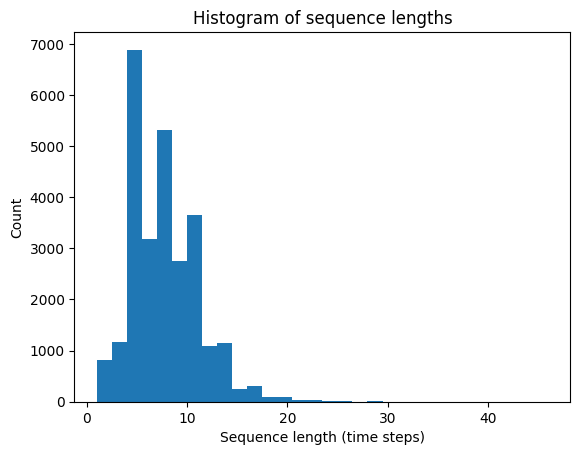


=== X normalization lists (based on TRAIN split stats) ===
x <- x / std (scale-only):
['intraoper_cumulative_HRV', 'intraoper_cumulative_hypothermia_auc', 'intraoper_cumulative_hypoxic_auc', 'intraoper_cumulative_MAP_auc', 'intraoper_FIO2_ArtBGA', 'intraoper_Oxygenation_index', 'intraoper_tHb_value', 'intraoper_BE_value', 'intraoper_cHCO3_value', 'intraoper_CVP_value', 'intraoper_Ca_value', 'intraoper_Na_value', 'intraoper_K_value', 'intraoper_Glu_value', 'intraoper_Lac_value', 'intraoper_PH_value', 'intraoper_Norepinephrine_max', 'intraoper_Dopamine_max', 'intraoper_Dobutamine_max', 'intraoper_Isoproterenol_max', 'intraoper_Adrenaline_max', 'intraoper_Milrinone_max', 'intraoper_Baquting_value', 'intraoper_Tranexamic_Acid_value', 'intraoper_Heparin_value', 'intraoper_protamine_value', 'intraoper_opioids_MME_value', 'intraoper_GCs_culmulative_value', 'intraoper_Platelets_culVolume', 'intraoper_Plasma_culVolume', 'intraoper_Autoblood_culVolume', 'CPBresidualBlood_culVolume', 'intraoper_

KeyboardInterrupt: 

In [ ]:
import argparse
import math
import random
from typing import Any, Dict, List, Optional, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam


# ============================================================
# Utils
# ============================================================

def set_all_seeds(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def reverse_padded_sequence(seq: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    """
    Reverse each sequence up to its length, keep padding.
    seq: (B, T, D)
    lengths: (B,)
    """
    B, T, D = seq.shape
    out = seq.clone()
    for i in range(B):
        L = int(lengths[i].item())
        if L > 0:
            out[i, :L, :] = torch.flip(seq[i, :L, :], dims=[0])
        if L < T:
            out[i, L:, :] = 0.0
    return out


# ============================================================
# Neural components
# ============================================================

class MLPEmbed(nn.Module):
    """Embed static covariates v -> v_emb."""
    def __init__(self, in_dim: int, out_dim: int, hidden_dim: int = 128, dropout: float = 0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class MLPNormal(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, min_scale=0.1, max_scale=0.8):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.loc = nn.Linear(hidden_dim, out_dim)
        self.scale = nn.Linear(hidden_dim, out_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
        self.min_scale = float(min_scale)
        self.max_scale = float(max_scale)

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        loc = self.loc(h)
        scale = (self.softplus(self.scale(h)) + self.min_scale).clamp(max=self.max_scale)
        return loc, scale


class MLPLogits(nn.Module):
    def __init__(self, in_dim, out_dim=1, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        return self.out(h)


class MLPCat(nn.Module):
    """Categorical logits from an MLP."""
    def __init__(self, in_dim, num_classes, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.tanh(self.fc2(h))
        return self.out(h)  # logits


class ContextCombiner(nn.Module):
    """
    q(z_t | context, g_t):
      context = [z_{t-1}, emb(a_{t-1}), v_emb]
      g_t = backward RNN message over [x,a,y,v]
    """
    def __init__(self, context_dim, g_dim, z_dim):
        super().__init__()
        self.lin_context_to_g = nn.Linear(context_dim, g_dim)
        self.lin_g_to_loc = nn.Linear(g_dim, z_dim)
        self.lin_g_to_scale = nn.Linear(g_dim, z_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()

    def forward(self, context, g_t):
        h = 0.5 * (self.tanh(self.lin_context_to_g(context)) + g_t)
        loc = self.lin_g_to_loc(h)
        scale = self.softplus(self.lin_g_to_scale(h)) + 1e-4
        return loc, scale


class GatedTransitionZCatAV(nn.Module):
    """
    DMM-style gated transition:
      p(z_t | z_{t-1}, a_{t-1}, v) = Normal(loc, scale)
    """
    def __init__(self, z_dim, a_emb_dim, v_emb_dim, transition_dim=64):
        super().__init__()
        in_dim = z_dim + a_emb_dim + v_emb_dim

        self.lin_gate = nn.Linear(in_dim, transition_dim)
        self.lin_gate_out = nn.Linear(transition_dim, z_dim)

        self.lin_prop = nn.Linear(in_dim, transition_dim)
        self.lin_prop_out = nn.Linear(transition_dim, z_dim)

        self.lin_sig = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)

        # identity init
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_tm1, a_tm1_emb, v_emb):
        zav = torch.cat([z_tm1, a_tm1_emb, v_emb], dim=-1)
        _gate = self.relu(self.lin_gate(zav))
        gate = torch.sigmoid(self.lin_gate_out(_gate))

        _prop = self.relu(self.lin_prop(zav))
        prop_mean = self.lin_prop_out(_prop)

        loc = (1.0 - gate) * self.lin_z_to_loc(z_tm1) + gate * prop_mean
        scale = self.softplus(self.lin_sig(self.relu(prop_mean))) + 1e-4
        return loc, scale


# ============================================================
# DynVAE model/guide (categorical a) + static covariates v
# ============================================================

class DynVAE_CatA(nn.Module):
    def __init__(
        self,
        dim_x=20,
        dim_z=3,
        num_actions=6,
        a_emb_dim=8,

        # static v
        dim_v=91,           # <-- requested
        v_emb_dim=32,
        v_hidden=128,

        dim_h=32,
        dim_g=32,
        transition_dim=64,
        hidden_dx=64,
        hidden_pa=64,
        hidden_y=64,
        num_layers=1,
        rnn_dropout=0.1,
        min_scale_x=0.1,
        max_scale_x=0.8,

        action_loss_weight=20.0, ######## 10-30
        action_class_weights=None,

        y_loss_weight=10.0, ######## 10-50
        y_class_weights=None,

        dim_f=32,
        hidden_qtilde=64,
        min_scale_z=1e-3,
        max_scale_z=5.0,

        device=None,
    ):
        super().__init__()
        self.dim_x = int(dim_x)
        self.dim_z = int(dim_z)
        self.K = int(num_actions)
        self.a_emb_dim = int(a_emb_dim)

        self.dim_v = int(dim_v)
        self.v_emb_dim = int(v_emb_dim)

        self.dim_h = int(dim_h)
        self.dim_g = int(dim_g)
        self.dim_f = int(dim_f)
        self.num_layers = int(num_layers)

        self.action_loss_weight = float(action_loss_weight)
        if action_class_weights is None:
            action_class_weights = torch.ones(self.K)
        self.register_buffer("action_class_weights", action_class_weights.float())

        self.y_loss_weight = float(y_loss_weight)
        if y_class_weights is None:
            y_class_weights = torch.ones(2)
        self.register_buffer("y_class_weights", y_class_weights.float())

        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # v encoder
        self.v_enc = MLPEmbed(in_dim=self.dim_v, out_dim=self.v_emb_dim, hidden_dim=v_hidden, dropout=0.0)

        # a embedding
        self.a_emb = nn.Embedding(self.K, self.a_emb_dim)

        # p(a_t | z_t, v)
        self.p_a = MLPCat(in_dim=self.dim_z + self.v_emb_dim, num_classes=self.K, hidden_dim=hidden_pa)

        # p(z_1)
        self.z1_loc = nn.Parameter(torch.zeros(self.dim_z))
        self.z1_unconstrained_scale = nn.Parameter(torch.zeros(self.dim_z))
        self.softplus = nn.Softplus()

        # p(z_t | z_{t-1}, a_{t-1}, v)
        self.p_z = GatedTransitionZCatAV(
            z_dim=self.dim_z,
            a_emb_dim=self.a_emb_dim,
            v_emb_dim=self.v_emb_dim,
            transition_dim=transition_dim,
        )

        # p(x_t | h_t)
        self.p_x = MLPNormal(in_dim=self.dim_h, out_dim=self.dim_x, hidden_dim=hidden_dx,
                             min_scale=min_scale_x, max_scale=max_scale_x)

        # p(y | z_T, a_T, v)
        self.p_y = MLPLogits(in_dim=self.dim_z + self.K + self.v_emb_dim, out_dim=1, hidden_dim=hidden_y)

        # generative GRU
        self.gen_rnn = nn.GRU(
            input_size=self.dim_z,
            hidden_size=self.dim_h,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.0,
            bidirectional=False,
        )

        # smoother backward GRU over [x, emb(a), y, v_emb]
        self.inf_rnn_bw = nn.GRU(
            input_size=self.dim_x + self.a_emb_dim + 1 + self.v_emb_dim,
            hidden_size=self.dim_g,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=(rnn_dropout if self.num_layers > 1 else 0.0),
            bidirectional=False,
        )

        # distillation forward GRU over [x, emb(a_{t-1}), v_emb]
        self.inf_rnn_fw = nn.GRU(
            input_size=self.dim_x + self.a_emb_dim + self.v_emb_dim,
            hidden_size=self.dim_f,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=(rnn_dropout if self.num_layers > 1 else 0.0),
            bidirectional=False,
        )
        self.q_tilde = MLPNormal(
            in_dim=self.dim_f,
            out_dim=self.dim_z,
            hidden_dim=hidden_qtilde,
            min_scale=min_scale_z,
            max_scale=max_scale_z,
        )

        # q(z_t | [z_{t-1}, emb(a_{t-1}), v_emb], g_t)
        self.combiner = ContextCombiner(
            context_dim=self.dim_z + self.a_emb_dim + self.v_emb_dim,
            g_dim=self.dim_g,
            z_dim=self.dim_z,
        )

        # init states
        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_h))
        self.g0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_g))
        self.f0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.dim_f))
        self.z_q0 = nn.Parameter(torch.zeros(self.dim_z))

        self.to(self.device)

    def p_z1_params(self, batch_size: int, device: torch.device):
        loc = self.z1_loc.unsqueeze(0).expand(batch_size, -1).to(device)
        scale = self.softplus(self.z1_unconstrained_scale).unsqueeze(0).expand(batch_size, -1).to(device) + 1e-4
        return loc, scale

    def model(
        self,
        batch_x,
        batch_a,
        batch_y,
        batch_v,
        batch_mask,
        batch_lengths,
        annealing_factor: float = 1.0,
        distill_weight: float = 0.0,
    ):
        pyro.module("DynVAE_CatA", self)

        x = batch_x.to(self.device)
        a = batch_a.to(self.device)
        y = batch_y.to(self.device)
        v = batch_v.to(self.device)
        mask = batch_mask.to(self.device)
        lengths = batch_lengths.to(self.device)

        B, T_max, _ = x.shape

        v_emb = self.v_enc(v)
        v_rep = v_emb.unsqueeze(1).expand(B, T_max, self.v_emb_dim)

        # distillation forward features f_t (optional)
        f = None
        distill_weight = float(distill_weight)
        if distill_weight > 0.0:
            a_shift = torch.zeros_like(a)
            a_shift[:, 1:] = a[:, :-1]
            a_shift_emb = self.a_emb(a_shift)
            w = torch.cat([x, a_shift_emb, v_rep], dim=-1) * mask.unsqueeze(-1).float()

            f_init = self.f0.expand(self.num_layers, B, self.dim_f).contiguous()
            packed_w = pack_padded_sequence(w, lengths.cpu(), batch_first=True, enforce_sorted=False)
            packed_f, _ = self.inf_rnn_fw(packed_w, f_init)
            f, _ = pad_packed_sequence(packed_f, batch_first=True, total_length=T_max)
            f = f * mask.unsqueeze(-1).float()

        h = self.h0.expand(self.num_layers, B, self.dim_h).contiguous()

        z_prev: Optional[torch.Tensor] = None
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)
        a_prev_emb = self.a_emb(a_prev_idx)

        beta = max(float(annealing_factor), 1e-8)

        with pyro.plate("batch", B):
            for t in pyro.markov(range(T_max)):
                mask_t = mask[:, t]

                if t == 0:
                    z_loc, z_scale = self.p_z1_params(B, self.device)
                else:
                    z_loc, z_scale = self.p_z(z_prev, a_prev_emb, v_emb)

                with poutine.scale(scale=beta):
                    z_t = pyro.sample(f"z_{t+1}", dist.Normal(z_loc, z_scale).to_event(1).mask(mask_t))

                if f is not None:
                    zt_loc_d, zt_scale_d = self.q_tilde(f[:, t, :])
                    log_qtilde = dist.Normal(zt_loc_d, zt_scale_d).log_prob(z_t.detach()).sum(-1)
                    pyro.factor(f"distill_{t+1}", distill_weight * mask_t.float() * log_qtilde)

                # a_t observed
                a_logits = self.p_a(torch.cat([z_t, v_emb], dim=-1))
                w_t = self.action_class_weights[a[:, t]].clamp_min(1e-6)
                w_t = torch.where(mask_t, w_t, torch.ones_like(w_t))
                with poutine.scale(scale=self.action_loss_weight * w_t):
                    pyro.sample(f"a_{t+1}", dist.Categorical(logits=a_logits).mask(mask_t), obs=a[:, t])

                # update h only on valid
                out, h_new = self.gen_rnn(z_t.unsqueeze(1), h)
                h = torch.where(mask_t.view(1, B, 1), h_new, h)
                h_t = out[:, 0, :]

                # x_t observed
                x_loc, x_scale = self.p_x(h_t)
                pyro.sample(f"x_{t+1}", dist.Normal(x_loc, x_scale).to_event(1).mask(mask_t), obs=x[:, t, :])

                # last valid z/a
                if t == 0:
                    z_prev = z_t
                else:
                    z_prev = torch.where(mask_t.unsqueeze(-1), z_t, z_prev)
                a_prev_idx = torch.where(mask_t, a[:, t], a_prev_idx)
                a_prev_emb = self.a_emb(a_prev_idx)

            # y observed
            aT_onehot = F.one_hot(a_prev_idx, num_classes=self.K).float()
            y_logits = self.p_y(torch.cat([z_prev, aT_onehot, v_emb], dim=-1))
            y_idx = y.view(-1).long().clamp(0, 1)
            w_y = self.y_class_weights[y_idx].clamp_min(1e-6)
            with poutine.scale(scale=self.y_loss_weight * w_y):
                pyro.sample("y", dist.Bernoulli(logits=y_logits).to_event(1), obs=y)

    def guide(
        self,
        batch_x,
        batch_a,
        batch_y,
        batch_v,
        batch_mask,
        batch_lengths,
        annealing_factor: float = 1.0,
        distill_weight: float = 0.0,
    ):
        pyro.module("DynVAE_CatA", self)

        x = batch_x.to(self.device)
        a = batch_a.to(self.device)
        y = batch_y.to(self.device)
        v = batch_v.to(self.device)
        mask = batch_mask.to(self.device)
        lengths = batch_lengths.to(self.device)

        B, T_max, _ = x.shape

        v_emb = self.v_enc(v)
        v_rep = v_emb.unsqueeze(1).expand(B, T_max, self.v_emb_dim)

        a_emb_t = self.a_emb(a)
        y_rep = y.unsqueeze(1).expand(B, T_max, 1)
        u = torch.cat([x, a_emb_t, y_rep, v_rep], dim=-1) * mask.unsqueeze(-1).float()

        u_rev = reverse_padded_sequence(u, lengths)
        g_init = self.g0.expand(self.num_layers, B, self.dim_g).contiguous()

        packed = pack_padded_sequence(u_rev, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.inf_rnn_bw(packed, g_init)
        g_rev, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=T_max)
        g = reverse_padded_sequence(g_rev, lengths) * mask.unsqueeze(-1).float()

        z_prev = self.z_q0.expand(B, self.dim_z)
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)
        a_prev_emb = self.a_emb(a_prev_idx)

        beta = max(float(annealing_factor), 1e-8)

        with pyro.plate("batch", B):
            for t in pyro.markov(range(T_max)):
                mask_t = mask[:, t]
                context = torch.cat([z_prev, a_prev_emb, v_emb], dim=-1)
                z_loc, z_scale = self.combiner(context, g[:, t, :])
                with poutine.scale(scale=beta):
                    z_t = pyro.sample(f"z_{t+1}", dist.Normal(z_loc, z_scale).to_event(1).mask(mask_t))

                z_prev = torch.where(mask_t.unsqueeze(-1), z_t, z_prev)
                a_prev_idx = torch.where(mask_t, a[:, t], a_prev_idx)
                a_prev_emb = self.a_emb(a_prev_idx)

    @torch.no_grad()
    def distill_kl_sum_count(self, x, a, y, v, mask, lengths, use_mean_z_prev: bool = True):
        """KL(q_phi || q_tilde) summed over valid time steps."""
        self.eval()
        x = x.to(self.device)
        a = a.to(self.device)
        y = y.to(self.device)
        v = v.to(self.device)
        mask = mask.to(self.device)
        lengths = lengths.to(self.device)

        B, T_max, _ = x.shape
        v_emb = self.v_enc(v)
        v_rep = v_emb.unsqueeze(1).expand(B, T_max, self.v_emb_dim)

        # g_t
        a_emb_t = self.a_emb(a)
        y_rep = y.unsqueeze(1).expand(B, T_max, 1)
        u = torch.cat([x, a_emb_t, y_rep, v_rep], dim=-1) * mask.unsqueeze(-1).float()

        u_rev = reverse_padded_sequence(u, lengths)
        g_init = self.g0.expand(self.num_layers, B, self.dim_g).contiguous()
        packed = pack_padded_sequence(u_rev, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.inf_rnn_bw(packed, g_init)
        g_rev, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=T_max)
        g = reverse_padded_sequence(g_rev, lengths) * mask.unsqueeze(-1).float()

        # f_t
        a_shift = torch.zeros_like(a)
        a_shift[:, 1:] = a[:, :-1]
        a_shift_emb = self.a_emb(a_shift)
        w = torch.cat([x, a_shift_emb, v_rep], dim=-1) * mask.unsqueeze(-1).float()

        f_init = self.f0.expand(self.num_layers, B, self.dim_f).contiguous()
        packed_w = pack_padded_sequence(w, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_f, _ = self.inf_rnn_fw(packed_w, f_init)
        f, _ = pad_packed_sequence(packed_f, batch_first=True, total_length=T_max)
        f = f * mask.unsqueeze(-1).float()

        loc_tilde, scale_tilde = self.q_tilde(f.reshape(-1, self.dim_f))
        loc_tilde = loc_tilde.reshape(B, T_max, self.dim_z)
        scale_tilde = scale_tilde.reshape(B, T_max, self.dim_z).clamp_min(1e-6)

        z_prev = self.z_q0.expand(B, self.dim_z)
        a_prev_idx = torch.zeros(B, dtype=torch.long, device=self.device)
        a_prev_emb = self.a_emb(a_prev_idx)

        kl_sum = x.new_zeros(())
        count = x.new_zeros(())

        for t in range(T_max):
            context = torch.cat([z_prev, a_prev_emb, v_emb], dim=-1)
            loc_phi, scale_phi = self.combiner(context, g[:, t, :])
            scale_phi = scale_phi.clamp_min(1e-6)

            q_phi_t = td.Normal(loc_phi, scale_phi)
            q_tilde_t = td.Normal(loc_tilde[:, t, :], scale_tilde[:, t, :])
            kl_bt = td.kl_divergence(q_phi_t, q_tilde_t).sum(-1)

            m = mask[:, t].float()
            kl_sum = kl_sum + (kl_bt * m).sum()
            count = count + m.sum()

            z_next = loc_phi if use_mean_z_prev else q_phi_t.rsample()
            z_prev = torch.where(mask[:, t].unsqueeze(-1), z_next, z_prev)
            a_prev_idx = torch.where(mask[:, t], a[:, t], a_prev_idx)
            a_prev_emb = self.a_emb(a_prev_idx)

        return kl_sum.detach(), count.detach()


# ============================================================
# KL annealing schedule
# ============================================================

def make_anneal_fn(steps_per_epoch, epochs, kl_start_epoch=0, ramp_fraction_of_remaining=0.5, eps=1e-8):
    total_steps = int(steps_per_epoch * epochs)
    start_step = int(steps_per_epoch * kl_start_epoch)
    remaining = max(0, total_steps - start_step)
    ramp_steps = max(1, int(ramp_fraction_of_remaining * remaining))

    def anneal(step):
        if step <= start_step:
            return float(eps)
        s = step - start_step
        return float(max(eps, min(1.0, s / float(ramp_steps))))

    info = {
        "total_steps": total_steps,
        "start_step": start_step,
        "ramp_steps": ramp_steps,
        "ramp_end_step": start_step + ramp_steps,
    }
    return anneal, info


# ============================================================
# Class weights (loader: x,a,y,v,lengths,mask)
# ============================================================

def compute_action_class_weights(train_loader, K: int):
    counts = torch.zeros(K)
    for _x, a, _y, _v, lengths, mask in train_loader:
        counts += torch.bincount(a[mask].flatten(), minlength=K).float()
    freq = counts / counts.sum().clamp_min(1.0)
    w = 1.0 / (freq + 1e-6)
    w = w / w.mean().clamp_min(1e-6)
    return w


def compute_binary_class_weights(train_loader):
    counts = torch.zeros(2)
    for _x, _a, y, _v, lengths, mask in train_loader:
        y_idx = y.view(-1).long().clamp(0, 1)
        counts += torch.bincount(y_idx, minlength=2).float()
    freq = counts / counts.sum().clamp_min(1.0)
    w = 1.0 / (freq + 1e-6)
    w = w / w.mean().clamp_min(1e-6)
    return w


# ============================================================
# Training
# ============================================================

def train_svi(
    train_loader,
    model: DynVAE_CatA,
    test_loader=None,
    epochs=80,
    lr=1e-3,
    kl_start_epoch=2,
    seed=0,
    log_every=1,
    num_particles=1,
    distill_weight=1.0,
):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()

    optim = ClippedAdam({"lr": lr, "clip_norm": 5.0})
    loss_fn = Trace_ELBO(num_particles=num_particles, vectorize_particles=(num_particles > 1))
    svi = SVI(model.model, model.guide, optim, loss=loss_fn)

    steps_per_epoch = len(train_loader)
    anneal_fn, info = make_anneal_fn(
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        kl_start_epoch=kl_start_epoch,
        ramp_fraction_of_remaining=0.5,
        eps=1e-8,
    )
    print(
        f"[info] steps/epoch={steps_per_epoch}, total_steps={info['total_steps']}, "
        f"kl_start_epoch={kl_start_epoch}, start_step={info['start_step']}, "
        f"ramp_steps={info['ramp_steps']}, ramp_end_step={info['ramp_end_step']}"
    )

    def _print_header():
        print("epoch |  train loss/t | test@1.0 loss/t |  beta || distill KL/t (q_phi || q_tilde)")
        print("----- | ------------ | -------------- | ----- || ---------------------------")

    step = 0
    beta = 1.0
    for epoch in range(1, epochs + 1):
        model.train()
        for x, a, y, v, lengths, mask in train_loader:
            step += 1
            beta = anneal_fn(step)
            svi.step(x, a, y, v, mask, lengths, annealing_factor=beta, distill_weight=distill_weight)

        model.eval()
        train_elbo = 0.0
        train_T = 0.0
        distill_kl_sum = 0.0
        distill_kl_count = 0.0

        with torch.no_grad():
            for x, a, y, v, lengths, mask in train_loader:
                train_elbo += float(
                    svi.evaluate_loss(x, a, y, v, mask, lengths, annealing_factor=beta, distill_weight=0.0)
                )
                train_T += float(lengths.sum().item())

                if distill_weight > 0.0:
                    kl_sum, kl_count = model.distill_kl_sum_count(x, a, y, v, mask, lengths)
                    distill_kl_sum += float(kl_sum.item())
                    distill_kl_count += float(kl_count.item())

        train_loss_per_t = train_elbo / max(train_T, 1.0)
        distill_kl_per_t = distill_kl_sum / max(distill_kl_count, 1.0)

        test_full_t = None
        if test_loader is not None:
            total_full = 0.0
            total_full_T = 0.0
            with torch.no_grad():
                for x, a, y, v, lengths, mask in test_loader:
                    total_full += float(
                        svi.evaluate_loss(x, a, y, v, mask, lengths, annealing_factor=1.0, distill_weight=0.0)
                    )
                    total_full_T += float(lengths.sum().item())
            test_full_t = total_full / max(total_full_T, 1.0)

        if epoch % log_every == 0:
            if epoch == 1 or epoch % 10 == 0:
                _print_header()
            if test_loader is None:
                print(f"{epoch:5d} | {train_loss_per_t:12.4f} | {'-':14s} | {beta:5.3f} || {distill_kl_per_t:27.4f}")
            else:
                print(f"{epoch:5d} | {train_loss_per_t:12.4f} | {test_full_t:14.4f} | {beta:5.3f} || {distill_kl_per_t:27.4f}")


# ============================================================
# Dataset / loaders (no z)
# ============================================================

class TrajectoryDataset(Dataset):
    """
    Each item:
      x: (T,dim_x) float
      a: (T,) long
      y: (1,) float
      v: (dim_v,) float
    """
    def __init__(self, trajectories: Sequence[Dict[str, Any]]):
        self.trajs = list(trajectories)

    def __len__(self) -> int:
        return len(self.trajs)

    def __getitem__(self, idx: int):
        tr = self.trajs[idx]
        x = torch.as_tensor(tr["x"], dtype=torch.float32)
        a = torch.as_tensor(tr["a"], dtype=torch.long)
        y = torch.as_tensor(tr["y"], dtype=torch.float32).view(1)
        v = torch.as_tensor(tr["v"], dtype=torch.float32)
        return x, a, y, v


def collate_trajectories(batch: List[Tuple[torch.Tensor, ...]]):
    xs, aas, ys, vs = zip(*batch)

    lengths = torch.tensor([x.shape[0] for x in xs], dtype=torch.long)
    T_max = int(lengths.max().item())

    x_pad = pad_sequence(xs, batch_first=True, padding_value=0.0)  # (B,T,dim_x)
    a_pad = pad_sequence(aas, batch_first=True, padding_value=0)   # (B,T)

    mask = (torch.arange(T_max)[None, :] < lengths[:, None])       # (B,T) bool

    v_stack = torch.stack(vs, dim=0)                               # (B,dim_v)
    y_stack = torch.stack(ys, dim=0)                               # (B,1)

    return x_pad, a_pad, y_stack, v_stack, lengths, mask


def make_toy_dataset(
    n: int,
    dim_x: int,
    dim_v: int,
    num_actions: int,
    min_T: int = 10,
    max_T: int = 30,
    seed: int = 0,
) -> List[Dict[str, Any]]:
    rng = np.random.default_rng(seed)
    trajs: List[Dict[str, Any]] = []
    for _ in range(n):
        T = int(rng.integers(min_T, max_T + 1))
        x = rng.normal(size=(T, dim_x)).astype(np.float32)
        a = rng.integers(0, num_actions, size=(T,), dtype=np.int64)
        y = rng.integers(0, 2, size=(1,), dtype=np.int64).astype(np.float32)
        v = rng.normal(size=(dim_v,)).astype(np.float32)
        trajs.append({"x": x, "a": a, "y": y, "v": v})
    return trajs


def build_loaders_from_npz(npz_path: str, batch_size: int, num_workers: int = 0):
    """
    Expected arrays in npz:
      - x: (N,T,dim_x) padded
      - a: (N,T) padded
      - y: (N,1)
      - v: (N,dim_v)
      - lengths: (N,)
    """
    data = np.load(npz_path)
    x = torch.tensor(data["x"], dtype=torch.float32)
    a = torch.tensor(data["a"], dtype=torch.long)
    y = torch.tensor(data["y"], dtype=torch.float32)
    v = torch.tensor(data["v"], dtype=torch.float32)
    lengths = torch.tensor(data["lengths"], dtype=torch.long)

    T_max = x.shape[1]
    mask = (torch.arange(T_max)[None, :] < lengths[:, None])

    class _Padded(Dataset):
        def __len__(self): return x.shape[0]
        def __getitem__(self, i):
            return x[i], a[i], y[i], v[i], lengths[i], mask[i]

    ds = _Padded()
    n_test = max(1, int(0.2 * len(ds)))
    n_train = len(ds) - n_test
    train_ds, test_ds = random_split(ds, [n_train, n_test], generator=torch.Generator().manual_seed(0))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader


# ============================================================
# Main (notebook-safe argparse)
# ============================================================

def main(argv=None):
    parser = argparse.ArgumentParser(add_help=True)
    parser.add_argument("--epochs", type=int, default=1000)
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--kl_start_epoch", type=int, default=2)
    parser.add_argument("--seed", type=int, default=0)

    # NOTEBOOK SAFE: ignore extra jupyter args like -f kernel.json
    if argv is None:
        args, _ = parser.parse_known_args()
    else:
        args, _ = parser.parse_known_args(argv)

    set_all_seeds(args.seed)

    # match your setup (edit if needed)
    dim_x = 39
    dim_z = 6
    num_actions = 7
    dim_v = 91

    train_loader, test_loader, report = create_loaders(
        use_incremental_for_cumulative_x=True,
        pid_width=None,
        normalize_x=True,
        normalize_v=True,
        scale_nonneg_only=True,
        plot_length_hist=True,
        asa_encoding="onehot",  # or "ordinal"
    )

    a_w = compute_action_class_weights(train_loader, K=num_actions)
    y_w = compute_binary_class_weights(train_loader)

    model = DynVAE_CatA(
        dim_x=dim_x,
        dim_z=dim_z,
        num_actions=num_actions,
        a_emb_dim=10,

        dim_v=dim_v,
        v_emb_dim=5,
        v_hidden=128,

        dim_h=64,
        dim_g=64,
        transition_dim=64,
        hidden_dx=64,
        hidden_pa=64,
        hidden_y=64,
        num_layers=1,
        rnn_dropout=0.1,
        min_scale_x=0.10,
        max_scale_x=0.80,

        action_loss_weight=10.0,
        action_class_weights=a_w,

        y_loss_weight=10.0,
        y_class_weights=y_w,

        dim_f=64,
        hidden_qtilde=64,
        min_scale_z=1e-3,
        max_scale_z=5.0,
    )

    train_svi(
        train_loader=train_loader,
        model=model,
        test_loader=test_loader,
        epochs=args.epochs,
        lr=args.lr,
        kl_start_epoch=args.kl_start_epoch,
        seed=args.seed,
        log_every=1,
        num_particles=1,
        distill_weight=1.0,
    )


# If running as a script, this works; in notebooks, just call main([])
if __name__ == "__main__":
    main()
